# Two-box model estimating the effects of touristic activities on lakes

This script runs a two-box (epilimnion-hypolimnion) model of a lake to estimate the effects of touristic activities. 

**Author**: Tomy Doda, tomy.doda@unil.ch \
**Last update**: dd.mm.2025

### Load the packages

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams.update({'svg.fonttype':'none', 'font.sans-serif':'Arial','font.size': 12}) # "none": to export text as text
import pandas as pd
from datetime import datetime, timezone, UTC, timedelta
import math
import cmocean
from functions import load_parameters
from compound import COMP
# Uncomment to have interactive figures:
%matplotlib widget 

***

### Options (to change for different simulations)

Specify the lake name, according to the files in the `lakes` folder:

In [2]:
lakename="muzelle"

Specify the processes to include among the following options, according to the files in the `processes` folder:
* sunscreen

In [3]:
processes=["sunscreen"]

Figure saving option:

In [4]:
savefig=False # If True, all figures are exported as png

***

### Load the parameters from csv files

Lake-specific parameters:

In [5]:
param_lake,_,_=load_parameters(os.path.join("lakes",lakename+".csv"))

Process and actvity-specific parameters:

In [6]:
param_process=dict()
units_process=dict()
param_act=dict()
for p in processes:
    param_process[p],units_process[p],_=load_parameters(os.path.join("processes",p+".csv"))
    act_name=param_process[p]["Activity"]
    param_act[act_name],_,_=load_parameters(os.path.join("activities",act_name+".csv"))

Simulation parameters:

In [7]:
param_sim,_,_=load_parameters(os.path.join("simulation","simulation.csv"))

### Create compound objects

In [8]:
modelled_compounds=dict()
for key,value in param_process.items():
    modelled_compounds[key]=COMP(name_comp=value["Name_compound"],act=value["Activity"])
    modelled_compounds[key].set_time_series(param_sim,value)

### Modelling

Run model for each compound

In [9]:
for key in modelled_compounds.keys():
    h_epi,h_hypo,pexp=modelled_compounds[key].predict_concentration(param_lake,param_act[param_process[key]["Activity"]],\
                                                  param_process[key],units_process[key])

Export results:

In [10]:
for key in modelled_compounds.keys():
    modelled_compounds[key].results_to_csv(os.path.join("results",key+".csv"))

Results exported to results\sunscreen.csv


### Figures

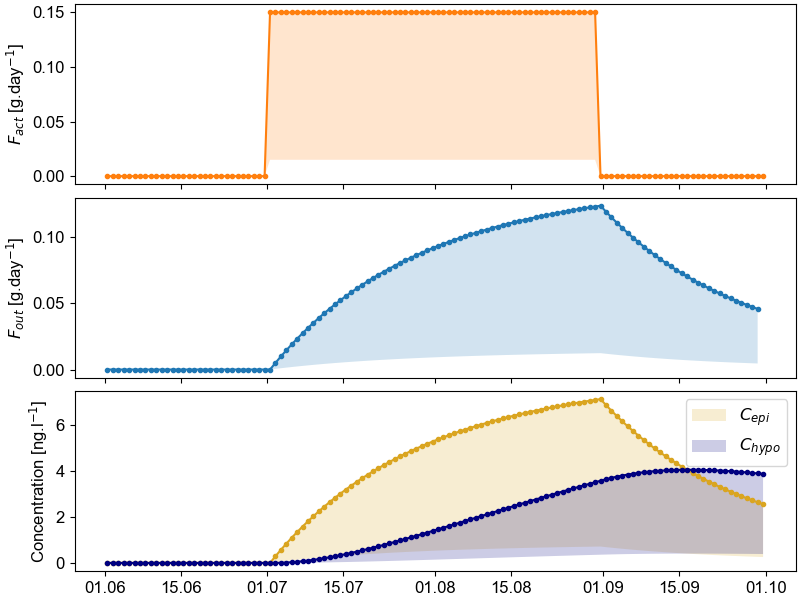

In [11]:
fig,ax=plt.subplots(3,1,figsize=(8,6),sharex=True,layout="constrained")

ax[0].fill_between(modelled_compounds["sunscreen"].data["tdate"],modelled_compounds["sunscreen"].data["Fact"][0,:]*86400,
                   modelled_compounds["sunscreen"].data["Fact"][1,:]*86400,facecolor='tab:orange',alpha=0.2)
ax[0].plot(modelled_compounds["sunscreen"].data["tdate"],modelled_compounds["sunscreen"].data["Fact"][1,:]*86400,'.-',color='tab:orange')
ax[0].set_ylabel("$F_{act}$ [g.day$^{-1}$]")


ax[1].fill_between(modelled_compounds["sunscreen"].data["tdate"],modelled_compounds["sunscreen"].data["Fout"][0,:]*86400,
                   modelled_compounds["sunscreen"].data["Fout"][1,:]*86400,facecolor='tab:blue',alpha=0.2)
ax[1].plot(modelled_compounds["sunscreen"].data["tdate"],modelled_compounds["sunscreen"].data["Fout"][1,:]*86400,'.-',color='tab:blue')
ax[1].set_ylabel("$F_{out}$ [g.day$^{-1}$]")

pepi=ax[2].fill_between(modelled_compounds["sunscreen"].data["tdate"],modelled_compounds["sunscreen"].data["conc_epi"][0,:]*1e6,
                   modelled_compounds["sunscreen"].data["conc_epi"][1,:]*1e6,facecolor='goldenrod',alpha=0.2)
ax[2].plot(modelled_compounds["sunscreen"].data["tdate"],modelled_compounds["sunscreen"].data["conc_epi"][1,:]*1e6,'.-',color='goldenrod')
phypo=ax[2].fill_between(modelled_compounds["sunscreen"].data["tdate"],modelled_compounds["sunscreen"].data["conc_hypo"][0,:]*1e6,
                   modelled_compounds["sunscreen"].data["conc_hypo"][1,:]*1e6,facecolor='navy',alpha=0.2)
ax[2].plot(modelled_compounds["sunscreen"].data["tdate"],modelled_compounds["sunscreen"].data["conc_hypo"][1,:]*1e6,'.-',color='navy')
ax[2].set_ylabel("Concentration [ng.l$^{-1}$]")
ax[2].legend([pepi,phypo],["$C_{epi}$","$C_{hypo}$"])

ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))
#ax[2].tick_params(axis='x', labelrotation=40)
